# _Please note that this notebook can not be trained on a Mac._

## Setup

In [1]:
import logging
import os
from pathlib import Path
from platform import system
import warnings
from zipfile import ZipFile

from datasets import Dataset, DatasetDict
from fastai.imports import *
import torch
from torch.utils.data import DataLoader
import transformers
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [2]:
try:
    from fastkaggle import *
except ModuleNotFoundError:
    ! pip install -Uq fastkaggle
    from fastkaggle import *

In [3]:
environment = system()

environment, iskaggle

('Darwin', '')

In [4]:
data_path = setup_comp('us-patent-phrase-to-phrase-matching')
# Not sure if I need to unzip.
ZipFile(f'{data_path}.zip').extractall(data_path)

## Explore Data

### Training Data

In [5]:
train_df = pd.read_csv(data_path / 'train.csv')
train_df

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


In [6]:
train_df.describe(include='object')

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


#### Targets

In [7]:
train_df['target'].value_counts()

composition                    24
data                           22
metal                          22
motor                          22
assembly                       21
                               ..
switching switch over valve     1
switching switch off valve      1
switching over valve            1
switching off valve             1
wooden substrate                1
Name: target, Length: 29340, dtype: int64

The vast majority of targets are unique. Most targets also contain very few
words. The least frequent targets tend to contain more than one word.

#### Anchors

In [8]:
train_df['anchor'].value_counts()

component composite coating              152
sheet supply roller                      150
source voltage                           140
perfluoroalkyl group                     136
el display                               135
                                        ... 
plug nozzle                                2
shannon                                    2
dry coating composition1                   2
peripheral nervous system stimulation      1
conduct conducting material                1
Name: anchor, Length: 733, dtype: int64

There are many targets than anchors. The length of each anchor varies quite a
 bit too, though they tend to be between 2-4 words.

#### Context

In [9]:
train_df['context'].value_counts()

H01    2186
H04    2177
G01    1812
A61    1477
F16    1091
       ... 
B03      47
F17      33
B31      24
A62      23
F26      18
Name: context, Length: 106, dtype: int64

The first letter in each context code references the section under which the
patent was filed

#### Scores

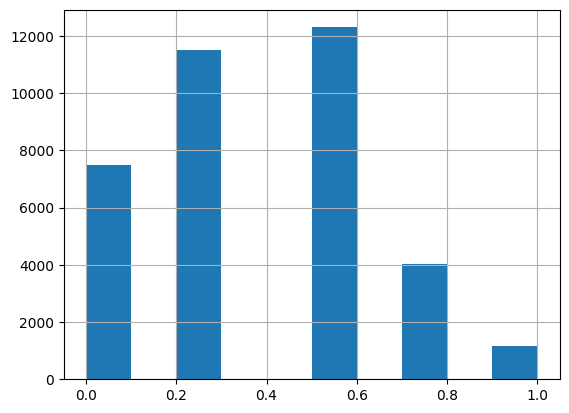

In [10]:
train_df['score'].hist();

Most patents seem to be somewhat similar or not very similar.

Below are the data points that have a score of 1.0.

In [11]:
train_df[train_df['score']==1]

,id,anchor,target,context,score
28,473137168ebf7484,abatement,abating,F24,1.0
158,621b048d70aa8867,absorbent properties,absorbent characteristics,D01,1.0
161,bc20a1c961cb073a,absorbent properties,absorption properties,D01,1.0
311,e955700dffd68624,acid absorption,absorption of acid,B08,1.0
315,3a09aba546aac675,acid absorption,acid absorption,B08,1.0
...,...,...,...,...,...
36398,913141526432f1d6,wiring trough,wiring troughs,F16,1.0
36435,ee0746f2a8ecef97,wood article,wood articles,B05,1.0
36440,ecaf479135cf0dfd,wood article,wooden article,B05,1.0
36464,8ceaa2b5c2d56250,wood article,wood article,B44,1.0


It can be seen that the anchors and targets that have scored 1.0 are minor
rewords of each other. Each patent's context doesn't seem to be playing a
significant role.

### Testing Data

In [12]:
test_df = pd.read_csv(data_path/'test.csv')
len(test_df)

36

In [13]:
test_df.head()

,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


In [14]:
test_df.describe(include='object')

,id,anchor,target,context
count,36,36,36,36
unique,36,34,36,29
top,4112d61851461f60,el display,inorganic photoconductor drum,G02
freq,1,2,1,3


## Data Processing

### Context Section

The first letter of each patent's context code refers to the section the
patent was filed under.

In [15]:
train_df['context'].value_counts()

H01    2186
H04    2177
G01    1812
A61    1477
F16    1091
       ... 
B03      47
F17      33
B31      24
A62      23
F26      18
Name: context, Length: 106, dtype: int64

Separating this letter into its own column may help
with performance.

In [16]:
train_df['section'] = train_df['context'].str[0]
train_df['section'].value_counts()

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: section, dtype: int64

### Tokenization and Numericalization

In [17]:
# Disabling warnings since Huggingface outputs them unnecessarily.
warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

I'll initially use deberta-v3-small for experimentation. The larger version
can be used at the end.

In [18]:
model_name = 'microsoft/deberta-v3-small'

In [19]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

I'll need to iterate on how to combine the anchors, targets, and contexts
together since there is not much research on this.

To begin with, I'll combine each data point's anchor, target, and context
into a single string. A special token will be used to separate these sections

In [20]:
separator = tokenizer.sep_token; separator

'[SEP]'

In [21]:
train_df['inputs'] = train_df['context'] + separator + train_df['anchor'] + \
                     separator + train_df['target']

Better performance is obtained when Pandas DataFrames are converted into
HuggingFace Datasets.

The `score` column will also be renamed to `label` in the training set, since
that
 is what
HuggingFace expects.

In [22]:
train_ds = Dataset.from_pandas(train_df).rename_column('score', 'label')
test_ds = Dataset.from_pandas(test_df)

In [23]:
def tokenize_function(document):
    return tokenizer(document['inputs'])

In [24]:
train_ds[0]

{'id': '37d61fd2272659b1',
 'anchor': 'abatement',
 'target': 'abatement of pollution',
 'context': 'A47',
 'label': 0.5,
 'section': 'A',
 'inputs': 'A47[SEP]abatement[SEP]abatement of pollution'}

In [25]:
tokenize_function(train_ds[0])

{'input_ids': [1, 336, 5753, 2, 47284, 2, 47284, 265, 6435, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

`1` and `2` are special tokens. `1` represents the start of a document and
`2` represents the separator token I used.

In [26]:
tokenizer.all_special_tokens

['[CLS]', '[SEP]', '[UNK]', '[PAD]', '[MASK]']

In [27]:
inputs = ('anchor', 'target', 'context',)
tok_train_ds = train_ds.map(tokenize_function, batched=True,
                            remove_columns=inputs+('inputs', 'id', 'section'))

  0%|          | 0/37 [00:00<?, ?ba/s]

In [28]:
tok_train_ds[0]

{'label': 0.5,
 'input_ids': [1, 336, 5753, 2, 47284, 2, 47284, 265, 6435, 2],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

### Validation Set

I'll create a validation set that contains anchors that are not present in
the training set.

In [29]:
anchors = train_df.anchor.unique()
np.random.seed(42)
np.random.shuffle(anchors)
anchors[:5]

array(['time digital signal', 'antiatherosclerotic', 'filled interior',
       'dispersed powder', 'locking formation'], dtype=object)

In [30]:
split_ratio = 0.25
valid_set_size = int(len(anchors) * split_ratio)
valid_set_size

183

In [31]:
valid_anchors = anchors[:valid_set_size]
valid_anchors[:5]

array(['time digital signal', 'antiatherosclerotic', 'filled interior',
       'dispersed powder', 'locking formation'], dtype=object)

In [32]:
valid_documents = np.isin(train_df['anchor'], valid_anchors)
indicies = np.arange(len(train_df))
valid_indices = indicies[valid_documents]
train_indicies = indicies[~valid_documents]
len(valid_indices), len(train_indicies)

(9116, 27357)

In [33]:
# If error with this dictionary, change 'valid' to 'train'.
ds_dict = DatasetDict({
    'train': tok_train_ds.select(train_indicies),
    'valid': tok_train_ds.select(valid_indices)
})

## Train Model

### Warning

In [34]:
class StopExecution(Exception):
    def _render_traceback_(self):
        return [
            "This training portion of this notebook can not be run on a Mac. "
            "Halting execution of the notebook now before training portion "
            "begins."
        ]

In [35]:
if environment == 'Darwin':
    raise StopExecution

StopExecution: 

### Metric Function

In [ ]:
def pearson_correlation(valid_prediction):
    return {'pearson': np.corrcoef(*valid_prediction)[0][1]}

### Other Hyperparameters

In [ ]:
learning_rate = 8e-5
batch_size = 128
weight_decay = 0.01
epochs = 4

### Training Arguments

In [ ]:
arguments = TrainingArguments(
    'outputs',
    learning_rate=learning_rate,
    warmup_ratio=0.1,
    lr_scheduler_type='cosine',
    fp16=True,
    evaluation_strategy='epoch',
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size*2,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    report_to='none'
)

### Trainer Creation

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                           num_labels=1)

In [ ]:
trainer = Trainer(
    model,
    arguments,
    train_dataset=ds_dict['train'],
    eval_dataset=ds_dict['valid'],
    tokenizer=tokenizer,
    compute_metrics=pearson_correlation
)

### Convenient Trainer Creation Function

In [ ]:
def get_trainer(ds_dict):
    arguments = TrainingArguments(
        'outputs',
        learning_rate=learning_rate,
        warmup_ratio=0.1,
        lr_scheduler_type='cosine',
        fp16=True,
        evaluation_strategy='epoch',
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size*2,
        num_train_epochs=epochs,
        weight_decay=weight_decay,
        report_to='none'
    )

    model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                               num_labels=1)

    return Trainer(
        model,
        arguments,
        train_dataset=ds_dict['train'],
        eval_dataset=ds_dict['valid'],
        tokenizer=tokenizer,
        compute_metrics=pearson_correlation
    )

### Train Trainer

In [ ]:
trainer.train()